## Импорт данных

In [561]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import ANN_classes as ann
import custom_classes as cc
from importlib import reload
import scipy.interpolate
from matplotlib.ticker import FuncFormatter

In [562]:
reload(ann)

<module 'ANN_classes' from '/home/quantumfox/JupyterWorkfolder/Py3/ANN/ANN_classes.py'>

In [563]:
ann.vercheck('0.10.0-test')

ANN vercheck OK


In [7]:
csvdata = []
with open('data_m.csv') as data_file:
    reader = csv.reader(data_file)
    for row in reader: 
        csvdata.append(row)
csvdata = np.array(csvdata, dtype=float)

## Представление данных

In [8]:
# по всем дням
n = csvdata[0]/1000
gv = csvdata[1]
gt = csvdata[2]
gv_s = np.sort(gv)
gt_s = np.sort(gt)

In [9]:
gtv_lookup = dict(zip(zip(gt,gv),n))

i = 0
n_surf = np.array([])
for row in range(32):
    for col in range(32):
        try:
            n_surf = np.append(n_surf, gtv_lookup[(gt_s[col],gv_s[row])])
        except KeyError:
            n_surf = np.append(n_surf, 0)
n_surf = n_surf.reshape(32,32)

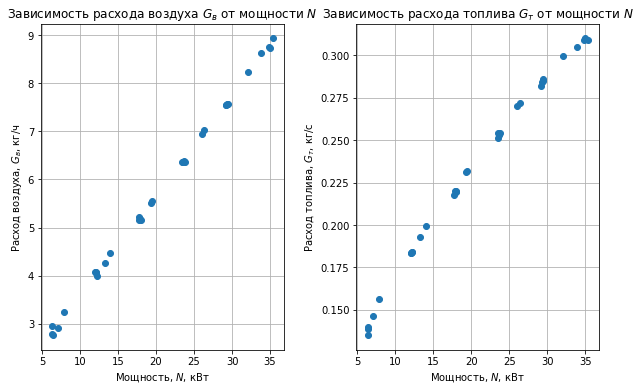

In [670]:
plt.figure(figsize=(10,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(n, gv, 'o')
ax2.plot(n, gt, 'o')
ax1.set_title(u'Зависимость расхода воздуха $G_в$ от мощности $N$')
ax1.set_ylabel(u'Расход воздуха, $G_в$, кг/ч')
ax1.set_xlabel(u'Мощность, $N$, кВт')
ax2.set_title(u'Зависимость расхода топлива $G_т$ от мощности $N$')
ax2.set_ylabel(u'Расход топлива, $G_т$, кг/с')
ax2.set_xlabel(u'Мощность, $N$, кВт')

ax1.grid()
ax2.grid()
plt.subplots_adjust(wspace=0.3)
plt.savefig('data_for_approx.eps')
plt.show()

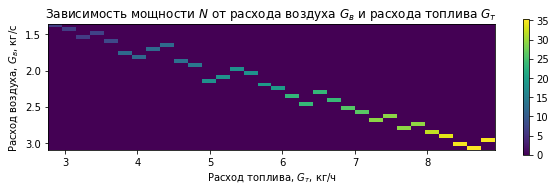

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(n_surf, extent=
          (gv_s.min(), gv_s.max(),
          gt_s.max()*10, gt_s.min()*10))
plt.colorbar(shrink=0.25)
plt.title(u'Зависимость мощности $N$ от расхода воздуха $G_в$ и расхода топлива $G_т$')
plt.xlabel(u'Расход топлива, $G_т$, кг/ч')
plt.ylabel(u'Расход воздуха, $G_в$, кг/с')
# plt.grid()
plt.show()

## Конфигурация и обучение нейросети

In [627]:
ann1 = ann.NNetwork_test(1,20,2)
ann1.nacc_tune(0.005)
ann1.nwgh_tune(0.3,0.1)
# ann1.nwgh_reset(0.4)
iterc = 0

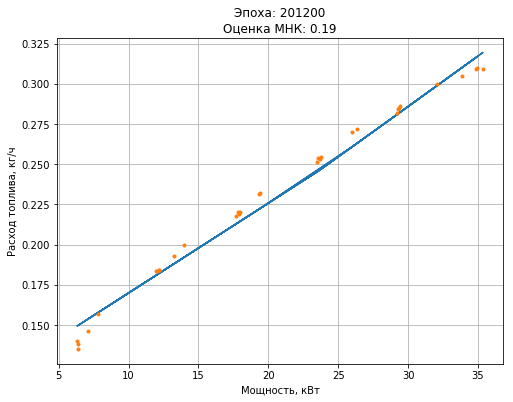

In [671]:
thresh = 0.15
for _ in range(50000):
    iterc += 1
    pick = np.random.randint(len(n))
    ann1.forward([n[pick]])
    ann1.getnetgrad([gt[pick], gv[pick]])
    ann1.backward()
    ann1.ncommit()
    ann_gt = [ann1.forward([n_it])[0][0] for n_it in n]
    ann_gv = [ann1.forward([n_it])[0][1] for n_it in n]
    err = cc.sqdistance(gt, ann_gt)
    if err < thresh:
        print(u'precision limit reached')
        break

plt.figure(figsize=(8,6))
plt.title(u'Эпоха: {0}\nОценка МНК: {1:3.2f}'
        .format(iterc, err))
plt.plot(n, ann_gt)
plt.plot(n, gt, '.')
plt.grid()
plt.xlabel(u'Мощность, кВт')
plt.ylabel(u'Расход топлива, кг/с')
plt.savefig('gt_approx.png')
plt.show()

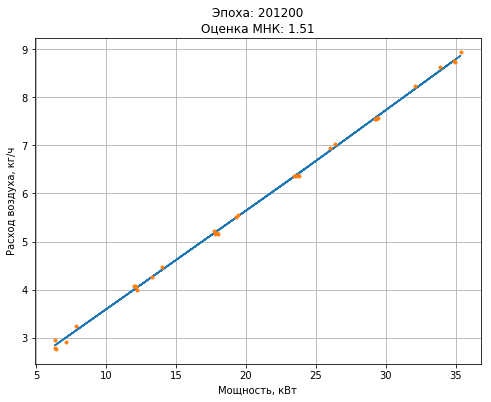

In [678]:
plt.figure(figsize=(8,6))
err = cc.sqdistance(ann_gv, gv)
plt.title(u'Эпоха: {0}\nОценка МНК: {1:3.2f}'
        .format(iterc, err))
plt.plot(n, ann_gv)
plt.plot(n, gv, '.')
plt.grid()
plt.xlabel(u'Мощность, кВт')
plt.ylabel(u'Расход воздуха, кг/ч')
plt.savefig('gv_approx.png')
plt.show()

In [1710]:
ann2 = ann.NNetwork(2,8,1)
ann2.cfg_input(2)
ann2.cfg_mass()
ann2.cfg_type()
# ann2.nwgh_randomize(4.,0.2)
ann2.nwgh_reset(1.)

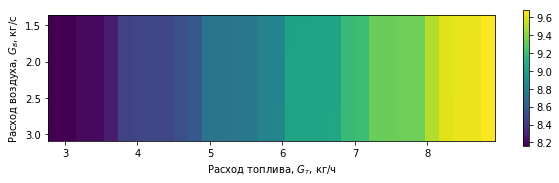

In [1786]:
for _ in range(100):
    pick = np.random.randint(len(gt))
    ann2.forward([gt[pick],gv[pick]])
    ann2.getnetgrad([n[pick]])
    ann2.backward()
    ann2.ncommit()

ann_n = np.array([])
for gt_it in gt_s:
    for gv_it in gv_s:
        ann2.forward([gt_it, gv_it])
        ann_n = np.append(ann_n, ann2.Loo[0].Voo.v)
ann_n = ann_n.reshape(32,32)

plt.figure(figsize=(10,10))
plt.imshow(ann_n, extent=
          (gv_s.min(), gv_s.max(),
          gt_s.max()*10, gt_s.min()*10))
plt.colorbar(shrink=0.25)
# plt.title(u'Зависимость мощности $N$ от расхода воздуха $G_в$ и расхода топлива $G_т$')
plt.xlabel(u'Расход топлива, $G_т$, кг/ч')
plt.ylabel(u'Расход воздуха, $G_в$, кг/с')
plt.show()